# **Предсказание статуса курильщика на основе био сигналов человека**

In [1]:
import numpy as np
import pandas as pd

import sys
import datetime
import time
import math

import lightgbm as lgb
import optuna.integration.lightgbm as lgbo
import optuna
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler, PowerTransformer, QuantileTransformer
le = preprocessing.LabelEncoder()
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_squared_log_error 
from sklearn.metrics import r2_score 
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import missingno as msno
import plotly.express as px
import xgboost as xgb
from catboost import CatBoostRegressor
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# **Чтение данных**

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s3e24/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e24/test.csv')
origin = pd.read_csv('/kaggle/input/train-dataset/train_dataset.csv')

In [3]:
train

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,0,55,165,60,81.0,0.5,0.6,1,1,135,87,94,172,300,40,75,16.5,1,1.0,22,25,27,0,1
1,1,70,165,65,89.0,0.6,0.7,2,2,146,83,147,194,55,57,126,16.2,1,1.1,27,23,37,1,0
2,2,20,170,75,81.0,0.4,0.5,1,1,118,75,79,178,197,45,93,17.4,1,0.8,27,31,53,0,1
3,3,35,180,95,105.0,1.5,1.2,1,1,131,88,91,180,203,38,102,15.9,1,1.0,20,27,30,1,0
4,4,30,165,60,80.5,1.5,1.0,1,1,121,76,91,155,87,44,93,15.4,1,0.8,19,13,17,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159251,159251,40,155,45,69.0,1.5,2.0,1,1,127,80,64,238,47,72,159,14.5,1,0.8,25,26,13,0,0
159252,159252,50,155,75,82.0,1.0,1.0,1,1,120,80,89,213,202,64,108,14.5,1,0.6,21,20,18,0,0
159253,159253,40,160,50,66.0,1.5,1.0,1,1,114,70,84,189,45,87,93,10.9,1,0.6,15,9,12,0,0
159254,159254,50,165,75,92.0,1.2,1.0,1,1,121,90,122,165,148,55,80,14.4,1,1.1,22,17,37,0,1


In [4]:
origin

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,35,170,85,97.0,0.9,0.9,1,1,118,78,97,239,153,70,142,19.8,1,1.0,61,115,125,1,1
1,20,175,110,110.0,0.7,0.9,1,1,119,79,88,211,128,71,114,15.9,1,1.1,19,25,30,1,0
2,45,155,65,86.0,0.9,0.9,1,1,110,80,80,193,120,57,112,13.7,3,0.6,1090,1400,276,0,0
3,45,165,80,94.0,0.8,0.7,1,1,158,88,249,210,366,46,91,16.9,1,0.9,32,36,36,0,0
4,20,165,60,81.0,1.5,0.1,1,1,109,64,100,179,200,47,92,14.9,1,1.2,26,28,15,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38979,40,165,60,80.0,0.4,0.6,1,1,107,60,93,144,53,61,72,12.3,1,0.5,18,18,21,1,0
38980,45,155,55,75.0,1.5,1.2,1,1,126,72,91,227,100,76,131,12.5,2,0.6,23,11,12,0,0
38981,40,170,105,124.0,0.6,0.5,1,1,141,85,115,225,196,48,138,17.1,1,0.8,24,23,35,1,1
38982,40,160,55,75.0,1.5,1.5,1,1,95,69,102,206,48,79,116,12.0,1,0.6,24,20,17,0,1


# **Анализ данных**

In [5]:
# Shape of dataset
train.shape

(159256, 24)

In [6]:
origin.shape

(38984, 23)

In [7]:
train.isna().sum()

id                     0
age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
smoking                0
dtype: int64

In [8]:
origin.isna().sum()

age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
smoking                0
dtype: int64

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159256 entries, 0 to 159255
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   159256 non-null  int64  
 1   age                  159256 non-null  int64  
 2   height(cm)           159256 non-null  int64  
 3   weight(kg)           159256 non-null  int64  
 4   waist(cm)            159256 non-null  float64
 5   eyesight(left)       159256 non-null  float64
 6   eyesight(right)      159256 non-null  float64
 7   hearing(left)        159256 non-null  int64  
 8   hearing(right)       159256 non-null  int64  
 9   systolic             159256 non-null  int64  
 10  relaxation           159256 non-null  int64  
 11  fasting blood sugar  159256 non-null  int64  
 12  Cholesterol          159256 non-null  int64  
 13  triglyceride         159256 non-null  int64  
 14  HDL                  159256 non-null  int64  
 15  LDL              

In [10]:
origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38984 entries, 0 to 38983
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  38984 non-null  int64  
 1   height(cm)           38984 non-null  int64  
 2   weight(kg)           38984 non-null  int64  
 3   waist(cm)            38984 non-null  float64
 4   eyesight(left)       38984 non-null  float64
 5   eyesight(right)      38984 non-null  float64
 6   hearing(left)        38984 non-null  int64  
 7   hearing(right)       38984 non-null  int64  
 8   systolic             38984 non-null  int64  
 9   relaxation           38984 non-null  int64  
 10  fasting blood sugar  38984 non-null  int64  
 11  Cholesterol          38984 non-null  int64  
 12  triglyceride         38984 non-null  int64  
 13  HDL                  38984 non-null  int64  
 14  LDL                  38984 non-null  int64  
 15  hemoglobin           38984 non-null 

In [11]:
train.describe()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
count,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000
mean,79627.500000,44.306626,165.266929,67.143662,83.001990,1.005798,1.000989,1.023974,1.023421,122.503648,76.874071,98.352552,195.796165,127.616046,55.852684,114.607682,14.796965,1.074233,0.892764,25.516853,26.550296,36.216004,0.197996,0.437365
std,45973.391572,11.842286,8.818970,12.586198,8.957937,0.402113,0.392299,0.152969,0.151238,12.729315,8.994642,15.329740,28.396959,66.188989,13.964141,28.158931,1.431213,0.347856,0.179346,9.464882,17.753070,31.204643,0.398490,0.496063
min,0.000000,20.000000,135.000000,30.000000,51.000000,0.100000,0.100000,1.000000,1.000000,77.000000,44.000000,46.000000,77.000000,8.000000,9.000000,1.000000,4.900000,1.000000,0.100000,6.000000,1.000000,2.000000,0.000000,0.000000
25%,39813.750000,40.000000,160.000000,60.000000,77.000000,0.800000,0.800000,1.000000,1.000000,114.000000,70.000000,90.000000,175.000000,77.000000,45.000000,95.000000,13.800000,1.000000,0.800000,20.000000,16.000000,18.000000,0.000000,0.000000
50%,79627.500000,40.000000,165.000000,65.000000,83.000000,1.000000,1.000000,1.000000,1.000000,121.000000,78.000000,96.000000,196.000000,115.000000,54.000000,114.000000,15.000000,1.000000,0.900000,24.000000,22.000000,27.000000,0.000000,0.000000
75%,119441.250000,55.000000,170.000000,75.000000,89.000000,1.200000,1.200000,1.000000,1.000000,130.000000,82.000000,103.000000,217.000000,165.000000,64.000000,133.000000,15.800000,1.000000,1.000000,29.000000,32.000000,44.000000,0.000000,1.000000
max,159255.000000,85.000000,190.000000,130.000000,127.000000,9.900000,9.900000,2.000000,2.000000,213.000000,133.000000,375.000000,393.000000,766.000000,136.000000,1860.000000,21.000000,6.000000,9.900000,778.000000,2914.000000,999.000000,1.000000,1.000000


In [12]:
origin.describe()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
count,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000
mean,44.127591,164.689488,65.938718,82.062115,1.014955,1.008768,1.025369,1.026190,121.475631,75.994408,99.342269,196.883491,126.749461,57.293146,115.081495,14.624264,1.086523,0.886030,26.198235,27.145188,39.905038,0.214421,0.367279
std,12.063564,9.187507,12.896581,9.326798,0.498527,0.493813,0.157246,0.159703,13.643521,9.658734,20.642741,36.353945,71.803143,14.617822,42.883163,1.566528,0.402107,0.220621,19.175595,31.309945,49.693843,0.410426,0.482070
min,20.000000,130.000000,30.000000,51.000000,0.100000,0.100000,1.000000,1.000000,71.000000,40.000000,46.000000,55.000000,8.000000,4.000000,1.000000,4.900000,1.000000,0.100000,6.000000,1.000000,2.000000,0.000000,0.000000
25%,40.000000,160.000000,55.000000,76.000000,0.800000,0.800000,1.000000,1.000000,112.000000,70.000000,89.000000,172.000000,74.000000,47.000000,91.000000,13.600000,1.000000,0.800000,19.000000,15.000000,17.000000,0.000000,0.000000
50%,40.000000,165.000000,65.000000,82.000000,1.000000,1.000000,1.000000,1.000000,120.000000,76.000000,96.000000,195.000000,108.000000,55.000000,113.000000,14.800000,1.000000,0.900000,23.000000,21.000000,26.000000,0.000000,0.000000
75%,55.000000,170.000000,75.000000,88.000000,1.200000,1.200000,1.000000,1.000000,130.000000,82.000000,104.000000,219.000000,160.000000,66.000000,136.000000,15.800000,1.000000,1.000000,29.000000,31.000000,44.000000,0.000000,1.000000
max,85.000000,190.000000,135.000000,129.000000,9.900000,9.900000,2.000000,2.000000,233.000000,146.000000,423.000000,445.000000,999.000000,359.000000,1860.000000,21.100000,6.000000,11.600000,1090.000000,2914.000000,999.000000,1.000000,1.000000


# **Использование оригинальных данных**

In [13]:
data_t_o = pd.concat([train, origin], ignore_index=True)
data_t_o = data_t_o.drop_duplicates()
data_t_o

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,0.0,55,165,60,81.0,0.5,0.6,1,1,135,87,94,172,300,40,75,16.5,1,1.0,22,25,27,0,1
1,1.0,70,165,65,89.0,0.6,0.7,2,2,146,83,147,194,55,57,126,16.2,1,1.1,27,23,37,1,0
2,2.0,20,170,75,81.0,0.4,0.5,1,1,118,75,79,178,197,45,93,17.4,1,0.8,27,31,53,0,1
3,3.0,35,180,95,105.0,1.5,1.2,1,1,131,88,91,180,203,38,102,15.9,1,1.0,20,27,30,1,0
4,4.0,30,165,60,80.5,1.5,1.0,1,1,121,76,91,155,87,44,93,15.4,1,0.8,19,13,17,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198234,NaN,40,170,65,77.0,1.5,1.5,1,1,110,62,91,187,84,79,91,16.1,1,0.9,28,43,36,1,1
198235,NaN,40,165,60,80.0,0.4,0.6,1,1,107,60,93,144,53,61,72,12.3,1,0.5,18,18,21,1,0
198236,NaN,45,155,55,75.0,1.5,1.2,1,1,126,72,91,227,100,76,131,12.5,2,0.6,23,11,12,0,0
198238,NaN,40,160,55,75.0,1.5,1.5,1,1,95,69,102,206,48,79,116,12.0,1,0.6,24,20,17,0,1


In [14]:
data_all = pd.concat([data_t_o, test], ignore_index=True)

data_all

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,0.0,55,165,60,81.0,0.5,0.6,1,1,135,87,94,172,300,40,75,16.5,1,1.0,22,25,27,0,1.0
1,1.0,70,165,65,89.0,0.6,0.7,2,2,146,83,147,194,55,57,126,16.2,1,1.1,27,23,37,1,0.0
2,2.0,20,170,75,81.0,0.4,0.5,1,1,118,75,79,178,197,45,93,17.4,1,0.8,27,31,53,0,1.0
3,3.0,35,180,95,105.0,1.5,1.2,1,1,131,88,91,180,203,38,102,15.9,1,1.0,20,27,30,1,0.0
4,4.0,30,165,60,80.5,1.5,1.0,1,1,121,76,91,155,87,44,93,15.4,1,0.8,19,13,17,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298889,265422.0,40,165,60,78.0,0.8,0.9,1,1,112,78,134,225,82,59,149,16.4,1,1.1,24,31,28,0,NaN
298890,265423.0,40,170,85,95.0,1.2,1.2,1,1,130,90,97,180,186,44,100,16.0,2,1.0,25,31,38,0,NaN
298891,265424.0,35,170,85,89.0,1.2,1.2,1,1,131,86,106,211,76,53,142,15.9,1,0.8,33,32,24,1,NaN
298892,265425.0,40,160,60,67.0,0.7,0.8,1,1,120,80,92,175,81,55,103,13.9,1,0.6,42,36,32,0,NaN


In [15]:
feat_train = train.columns.drop('id').tolist()
feat_train

['age',
 'height(cm)',
 'weight(kg)',
 'waist(cm)',
 'eyesight(left)',
 'eyesight(right)',
 'hearing(left)',
 'hearing(right)',
 'systolic',
 'relaxation',
 'fasting blood sugar',
 'Cholesterol',
 'triglyceride',
 'HDL',
 'LDL',
 'hemoglobin',
 'Urine protein',
 'serum creatinine',
 'AST',
 'ALT',
 'Gtp',
 'dental caries',
 'smoking']

In [16]:
feat_test = test.columns.drop('id').tolist()
feat_test

['age',
 'height(cm)',
 'weight(kg)',
 'waist(cm)',
 'eyesight(left)',
 'eyesight(right)',
 'hearing(left)',
 'hearing(right)',
 'systolic',
 'relaxation',
 'fasting blood sugar',
 'Cholesterol',
 'triglyceride',
 'HDL',
 'LDL',
 'hemoglobin',
 'Urine protein',
 'serum creatinine',
 'AST',
 'ALT',
 'Gtp',
 'dental caries']

# **Квантили**

In [17]:
data_all[feat_train].describe().T\
        .style.bar(subset=['mean'], color=px.colors.qualitative.G10[0])\
        .background_gradient(subset=['std'], cmap='Greens')\
        .background_gradient(subset=['50%'], cmap='BuGn')

,count,mean,std,min,25%,50%,75%,max
age,298894.000000,44.332124,11.887929,20.000000,40.000000,40.000000,55.000000,85.000000
height(cm),298894.000000,165.185511,8.870147,130.000000,160.000000,165.000000,170.000000,190.000000
weight(kg),298894.000000,67.001395,12.625023,30.000000,60.000000,65.000000,75.000000,135.000000
waist(cm),298894.000000,82.898178,8.998734,51.000000,77.000000,83.000000,89.000000,129.000000
eyesight(left),298894.000000,1.006337,0.412205,0.100000,0.800000,1.000000,1.200000,9.900000
eyesight(right),298894.000000,1.001413,0.403260,0.100000,0.800000,1.000000,1.200000,9.900000
hearing(left),298894.000000,1.024216,0.153719,1.000000,1.000000,1.000000,1.000000,2.000000
hearing(right),298894.000000,1.023915,0.152784,1.000000,1.000000,1.000000,1.000000,2.000000
systolic,298894.000000,122.381095,12.854743,71.000000,113.000000,121.000000,130.000000,233.000000
relaxation,298894.000000,76.759206,9.085335,40.000000,70.000000,78.000000,82.000000,146.000000


In [18]:
list_feat = ['hearing(left)', 'hearing(right)', 'dental caries']
data_all = pd.get_dummies(data_all, columns=list_feat, dtype='uint8')
data_all

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,smoking,hearing(left)_1,hearing(left)_2,hearing(right)_1,hearing(right)_2,dental caries_0,dental caries_1
0,0.0,55,165,60,81.0,0.5,0.6,135,87,94,172,300,40,75,16.5,1,1.0,22,25,27,1.0,1,0,1,0,1,0
1,1.0,70,165,65,89.0,0.6,0.7,146,83,147,194,55,57,126,16.2,1,1.1,27,23,37,0.0,0,1,0,1,0,1
2,2.0,20,170,75,81.0,0.4,0.5,118,75,79,178,197,45,93,17.4,1,0.8,27,31,53,1.0,1,0,1,0,1,0
3,3.0,35,180,95,105.0,1.5,1.2,131,88,91,180,203,38,102,15.9,1,1.0,20,27,30,0.0,1,0,1,0,0,1
4,4.0,30,165,60,80.5,1.5,1.0,121,76,91,155,87,44,93,15.4,1,0.8,19,13,17,1.0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298889,265422.0,40,165,60,78.0,0.8,0.9,112,78,134,225,82,59,149,16.4,1,1.1,24,31,28,NaN,1,0,1,0,1,0
298890,265423.0,40,170,85,95.0,1.2,1.2,130,90,97,180,186,44,100,16.0,2,1.0,25,31,38,NaN,1,0,1,0,1,0
298891,265424.0,35,170,85,89.0,1.2,1.2,131,86,106,211,76,53,142,15.9,1,0.8,33,32,24,NaN,1,0,1,0,0,1
298892,265425.0,40,160,60,67.0,0.7,0.8,120,80,92,175,81,55,103,13.9,1,0.6,42,36,32,NaN,1,0,1,0,1,0


In [19]:
feat_test = data_all.columns.drop(['id', 'smoking']).tolist()

In [20]:
train = data_all.loc[data_t_o.index[0]:data_t_o.index[-1]-5517]
test = data_all.loc[data_t_o.index[-1]+1-5517:]

In [21]:
train

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,smoking,hearing(left)_1,hearing(left)_2,hearing(right)_1,hearing(right)_2,dental caries_0,dental caries_1
0,0.0,55,165,60,81.0,0.5,0.6,135,87,94,172,300,40,75,16.5,1,1.0,22,25,27,1.0,1,0,1,0,1,0
1,1.0,70,165,65,89.0,0.6,0.7,146,83,147,194,55,57,126,16.2,1,1.1,27,23,37,0.0,0,1,0,1,0,1
2,2.0,20,170,75,81.0,0.4,0.5,118,75,79,178,197,45,93,17.4,1,0.8,27,31,53,1.0,1,0,1,0,1,0
3,3.0,35,180,95,105.0,1.5,1.2,131,88,91,180,203,38,102,15.9,1,1.0,20,27,30,0.0,1,0,1,0,0,1
4,4.0,30,165,60,80.5,1.5,1.0,121,76,91,155,87,44,93,15.4,1,0.8,19,13,17,1.0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192718,NaN,40,170,65,77.0,1.5,1.5,110,62,91,187,84,79,91,16.1,1,0.9,28,43,36,1.0,1,0,1,0,0,1
192719,NaN,40,165,60,80.0,0.4,0.6,107,60,93,144,53,61,72,12.3,1,0.5,18,18,21,0.0,1,0,1,0,0,1
192720,NaN,45,155,55,75.0,1.5,1.2,126,72,91,227,100,76,131,12.5,2,0.6,23,11,12,0.0,1,0,1,0,1,0
192721,NaN,40,160,55,75.0,1.5,1.5,95,69,102,206,48,79,116,12.0,1,0.6,24,20,17,1.0,1,0,1,0,1,0


In [22]:
test

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,smoking,hearing(left)_1,hearing(left)_2,hearing(right)_1,hearing(right)_2,dental caries_0,dental caries_1
192723,159256.0,40,165,70,84.0,1.2,1.2,130,89,107,200,186,49,115,14.2,1,0.9,19,25,32,NaN,1,0,1,0,1,0
192724,159257.0,80,160,60,93.0,1.0,1.0,144,72,93,172,158,35,104,13.0,1,1.1,20,12,24,NaN,0,1,0,1,1,0
192725,159258.0,60,170,70,86.5,0.6,0.7,117,75,92,161,173,39,88,15.4,1,1.4,38,60,36,NaN,1,0,1,0,1,0
192726,159259.0,40,160,50,67.0,0.3,0.4,116,62,91,213,47,75,128,14.5,1,0.6,25,18,10,NaN,1,0,1,0,0,1
192727,159260.0,40,170,75,89.4,1.0,0.9,132,94,79,170,100,39,123,16.5,1,1.0,30,39,27,NaN,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298889,265422.0,40,165,60,78.0,0.8,0.9,112,78,134,225,82,59,149,16.4,1,1.1,24,31,28,NaN,1,0,1,0,1,0
298890,265423.0,40,170,85,95.0,1.2,1.2,130,90,97,180,186,44,100,16.0,2,1.0,25,31,38,NaN,1,0,1,0,1,0
298891,265424.0,35,170,85,89.0,1.2,1.2,131,86,106,211,76,53,142,15.9,1,0.8,33,32,24,NaN,1,0,1,0,0,1
298892,265425.0,40,160,60,67.0,0.7,0.8,120,80,92,175,81,55,103,13.9,1,0.6,42,36,32,NaN,1,0,1,0,1,0


# **Графики**

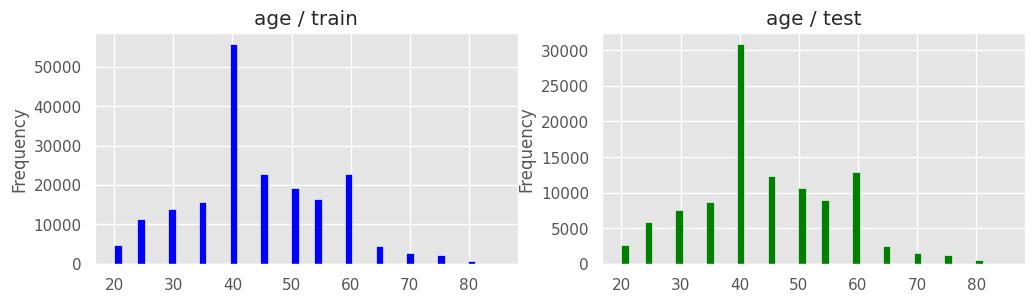

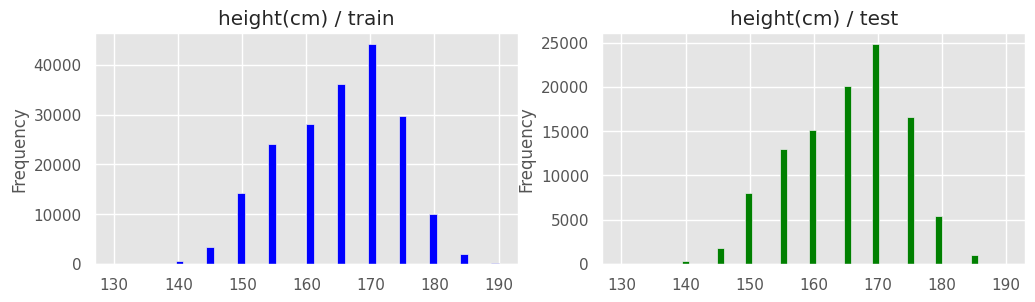

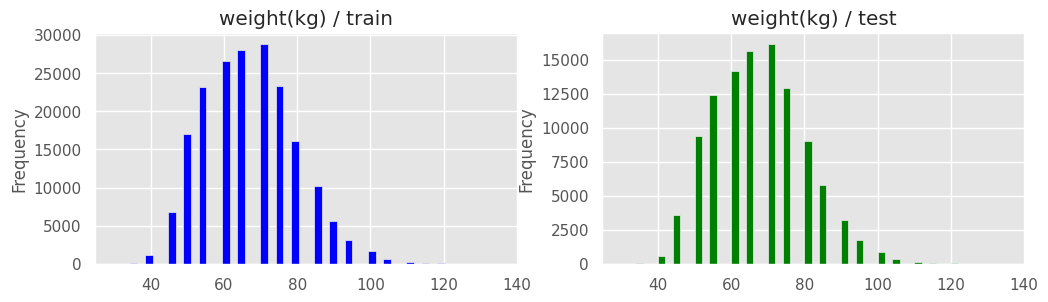

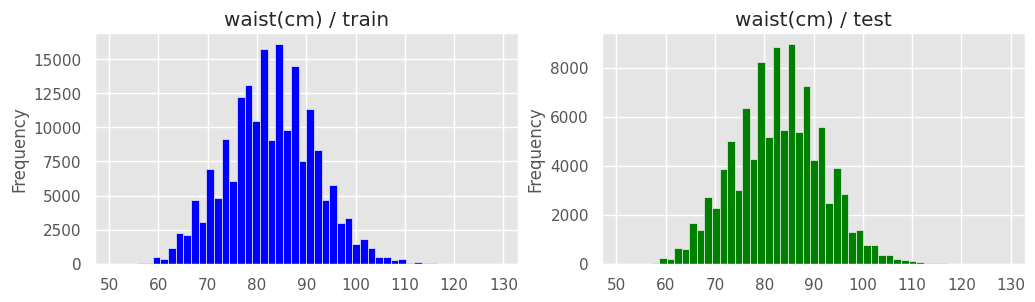

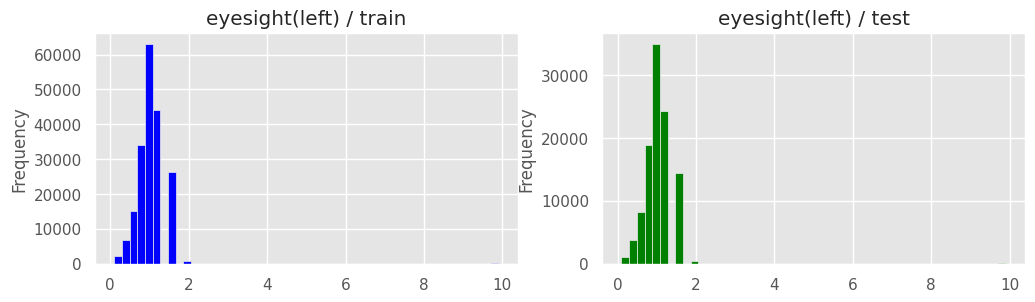

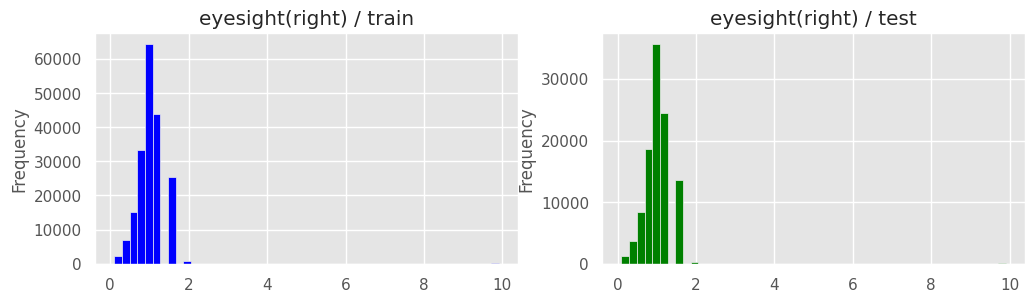

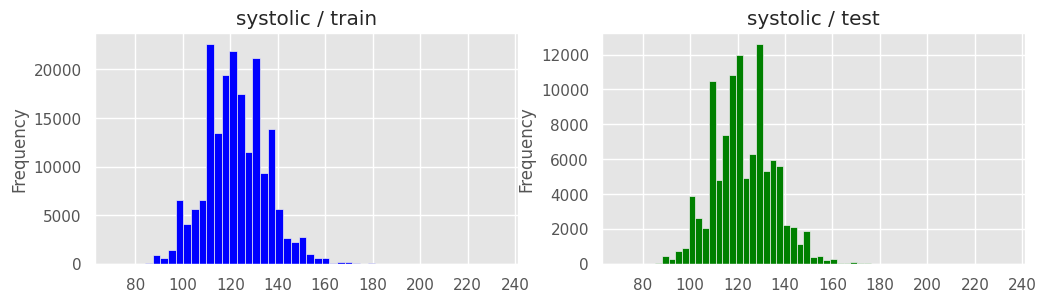

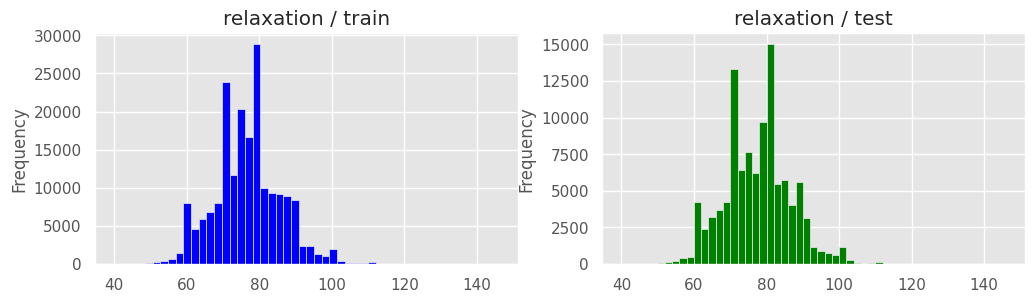

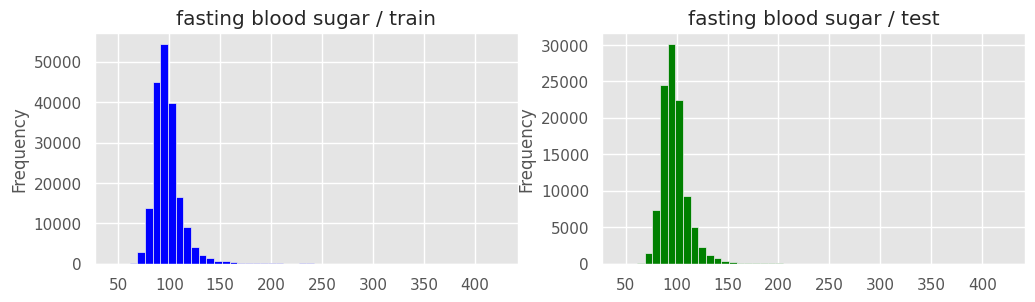

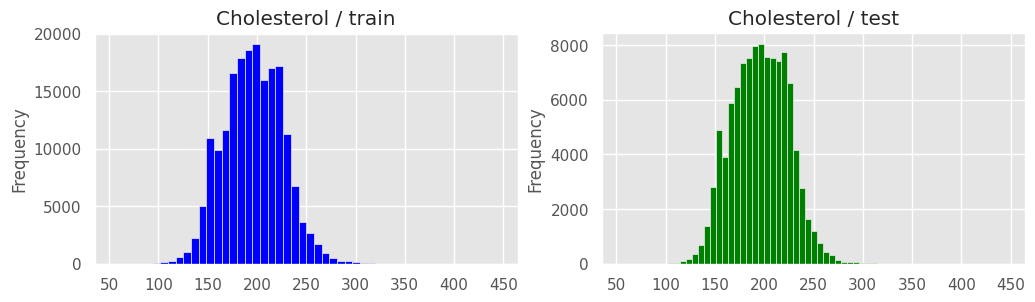

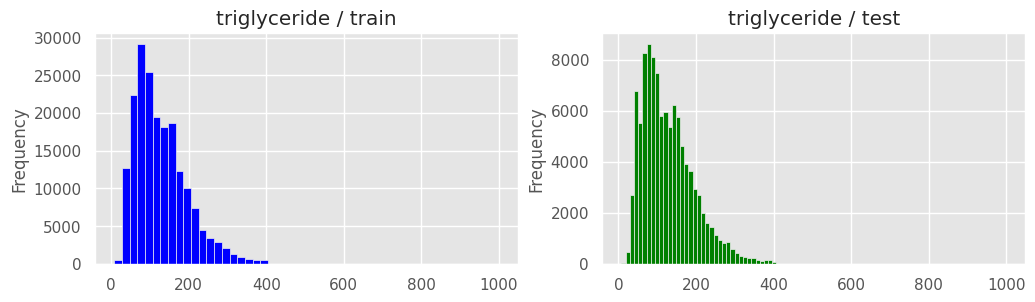

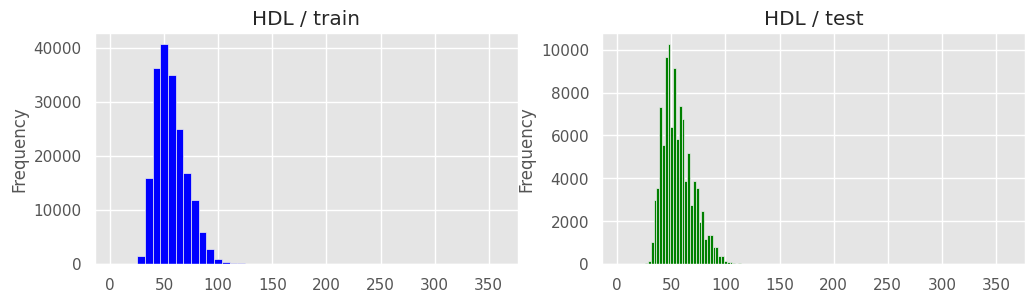

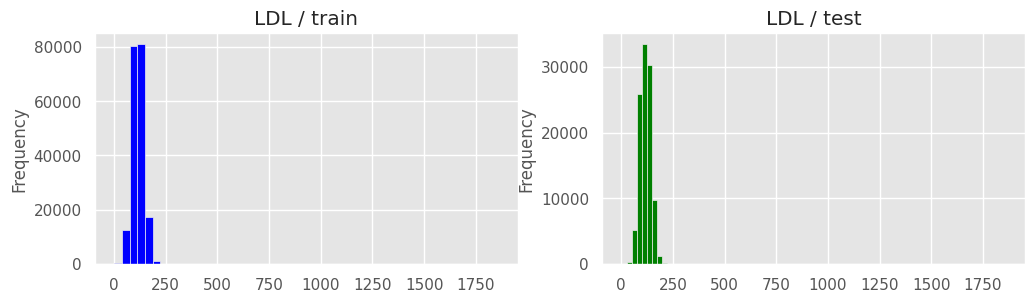

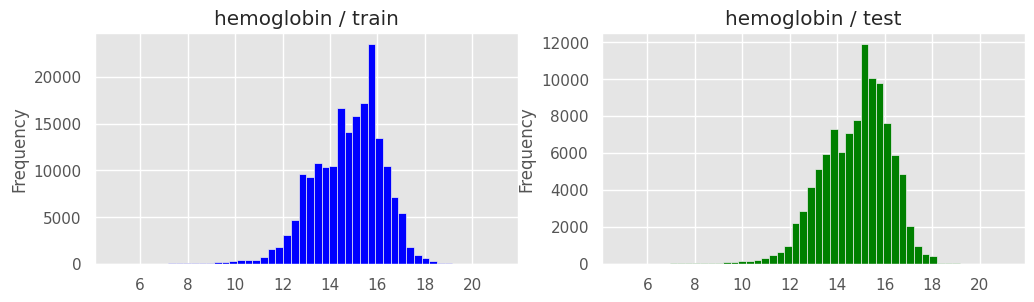

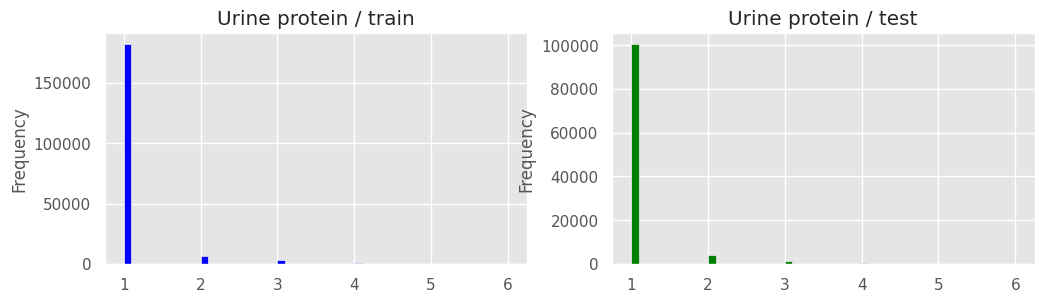

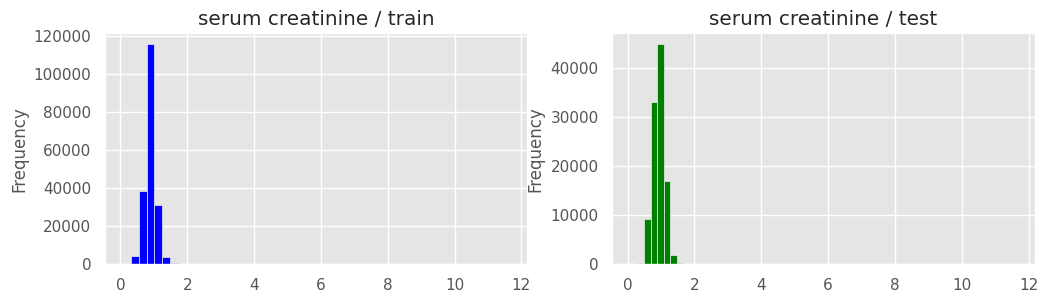

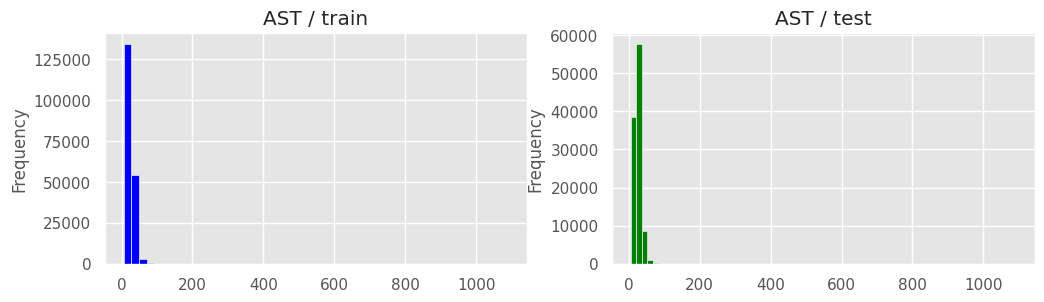

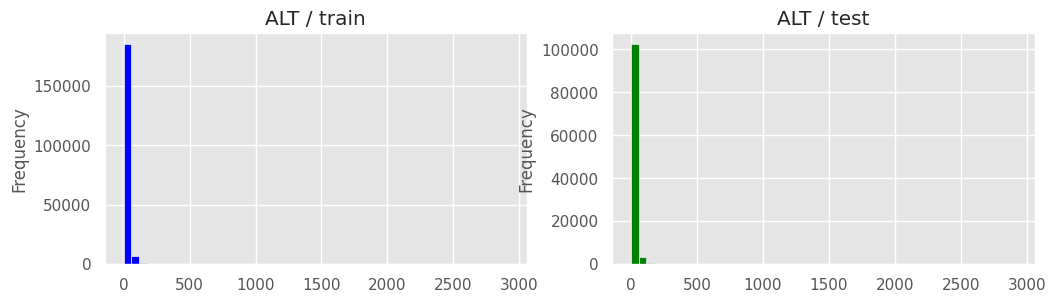

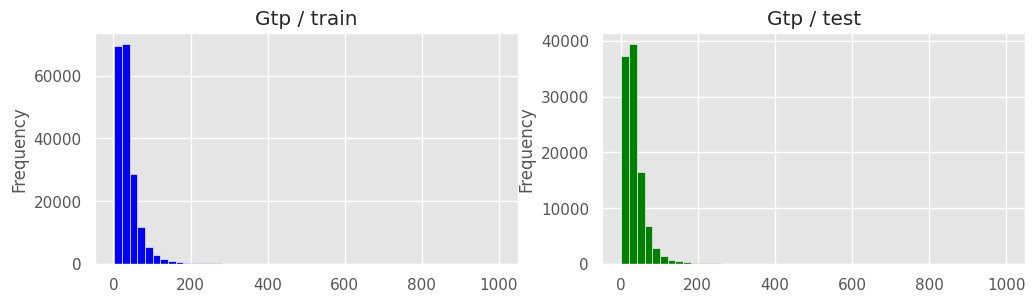

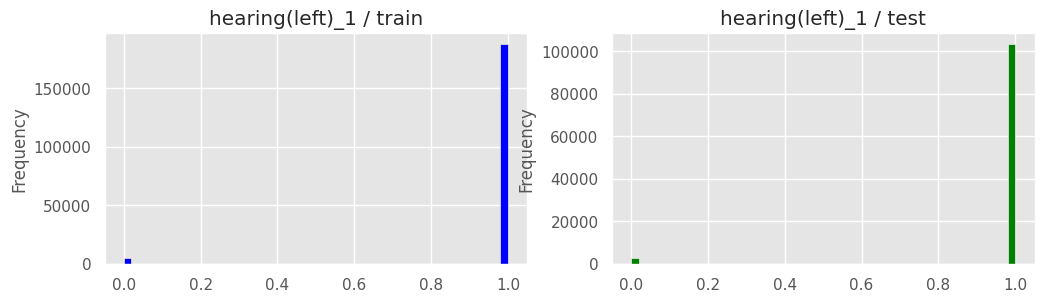

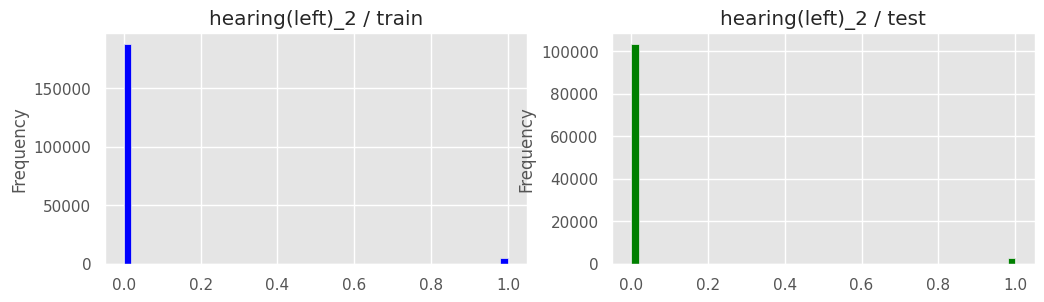

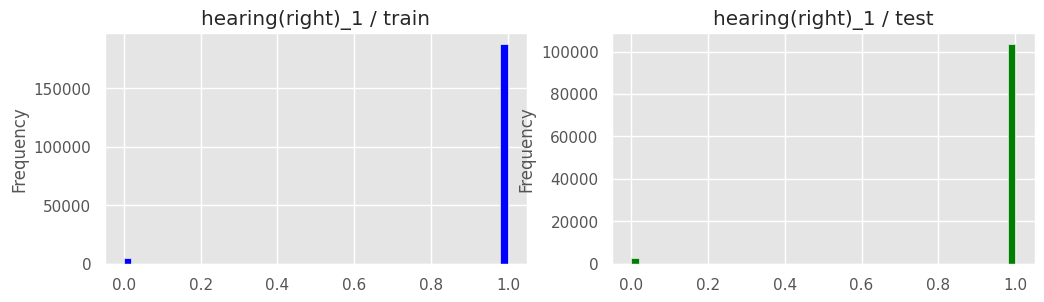

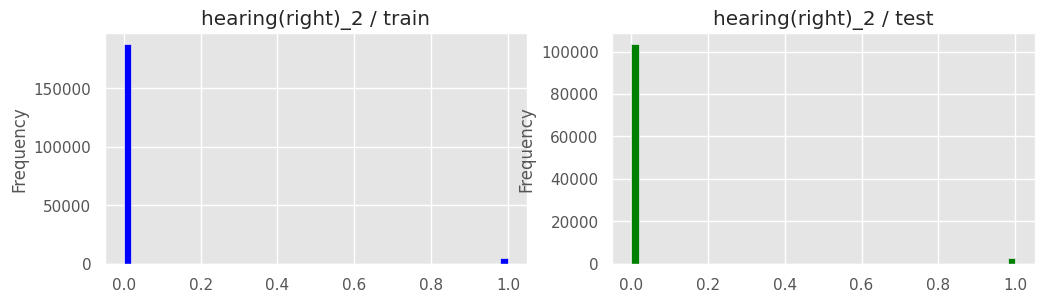

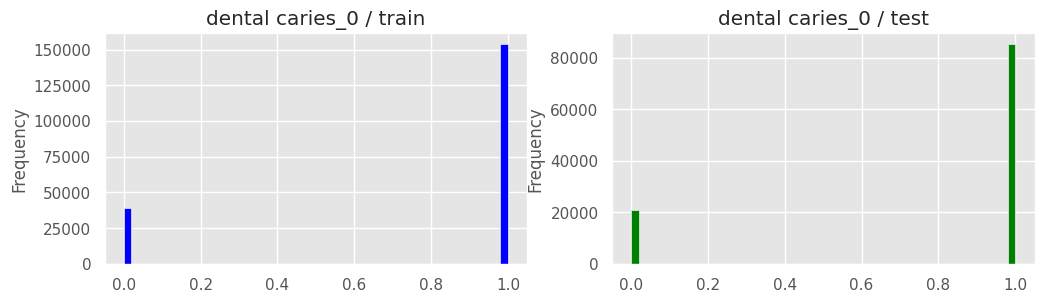

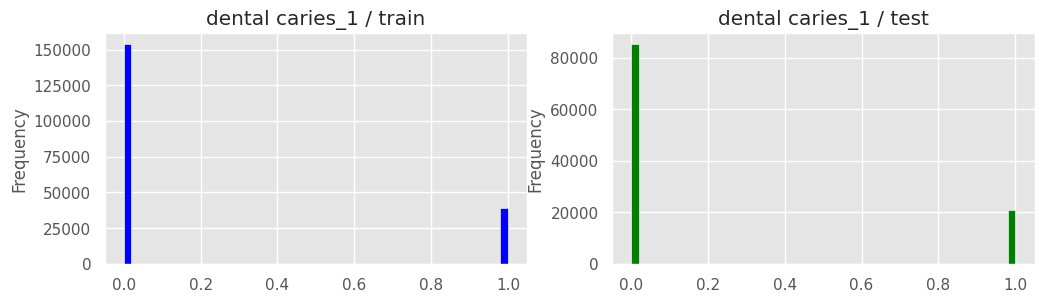

In [23]:
for feat in feat_test:
    plt.figure(figsize=(12,3))
    ax1 = plt.subplot(1,2,1)
    train[feat].plot(kind='hist', bins=50, color='blue')
    plt.title(feat + ' / train')
    ax2 = plt.subplot(1,2,2, sharex=ax1)
    test[feat].plot(kind='hist', bins=50, color='green')
    plt.title(feat + ' / test')
    plt.show()

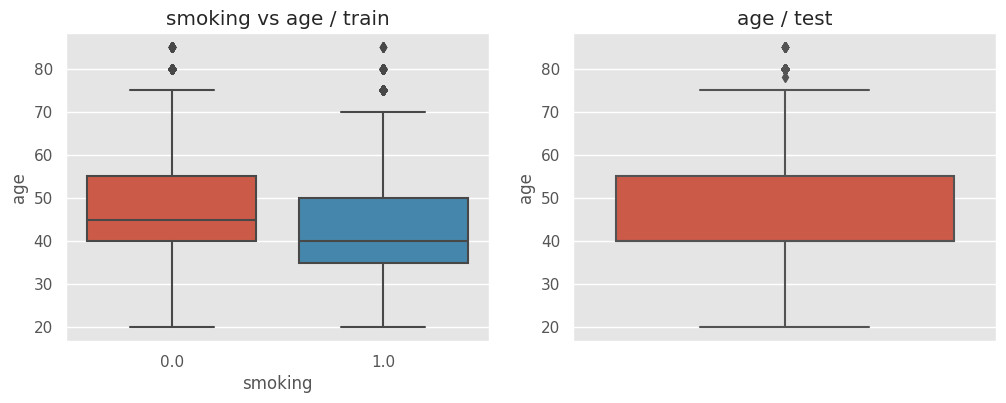

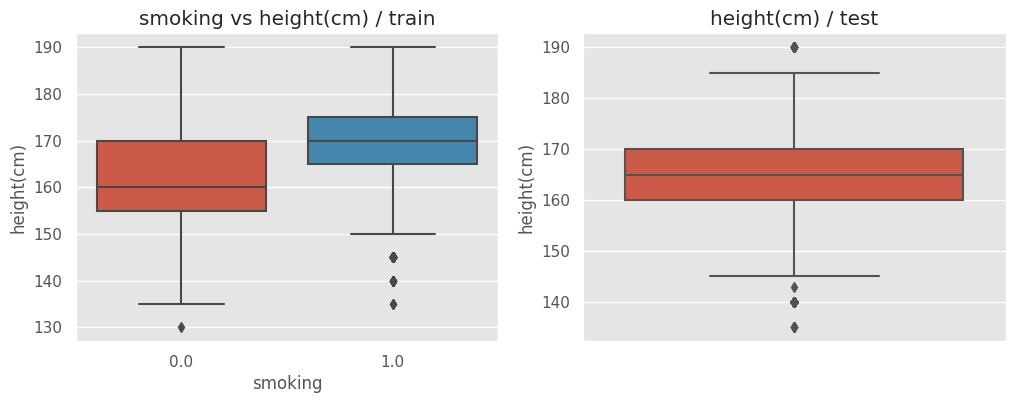

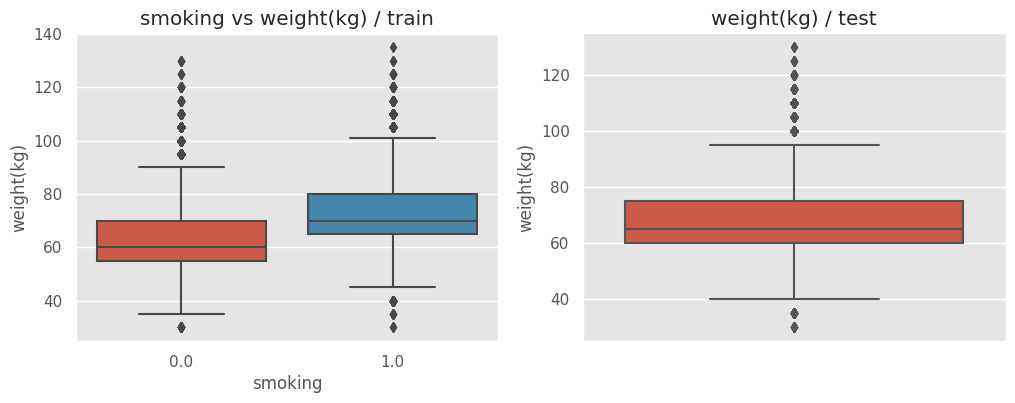

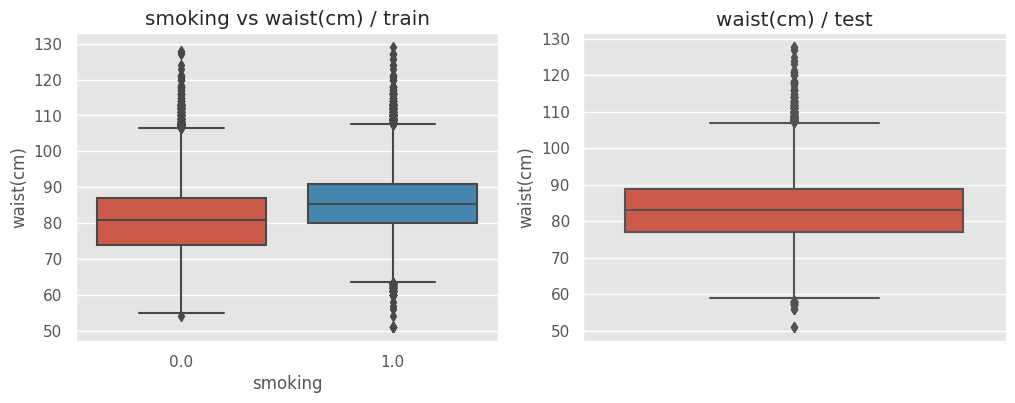

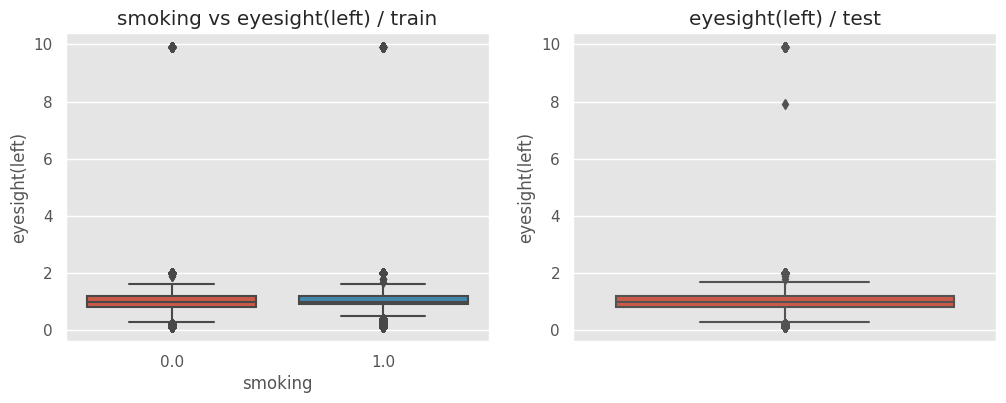

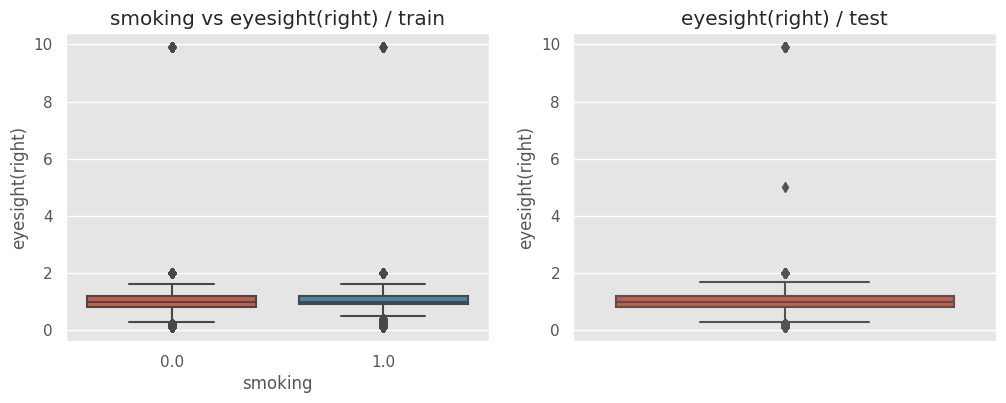

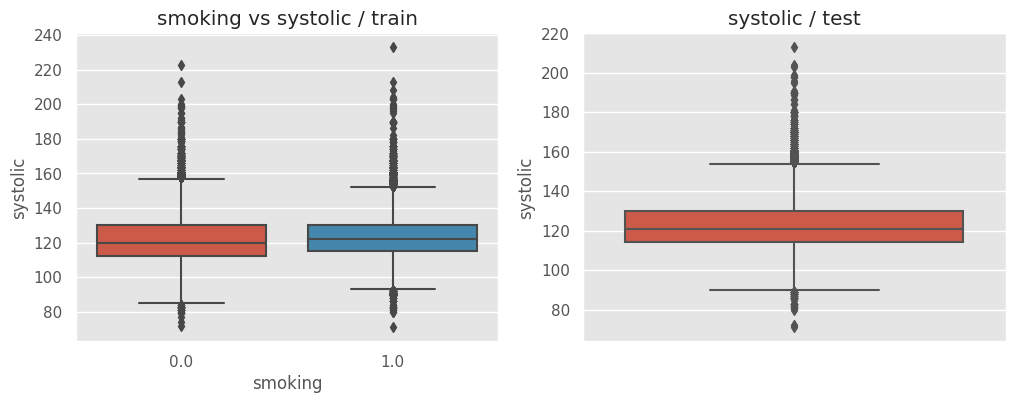

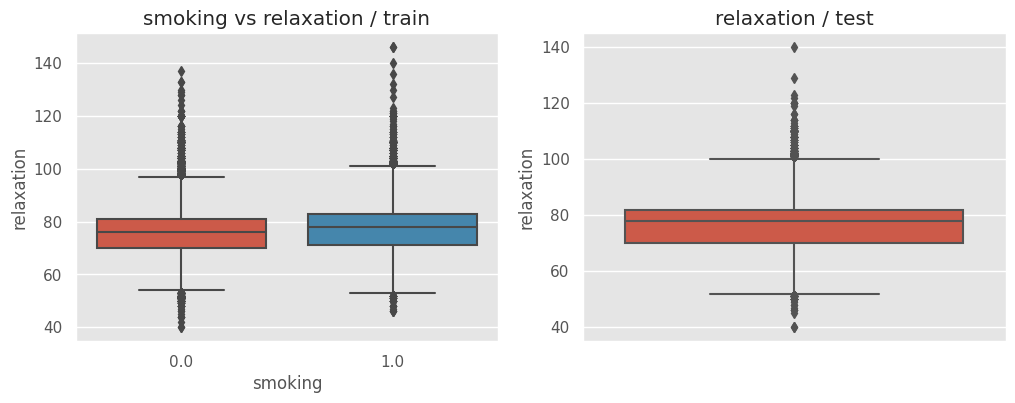

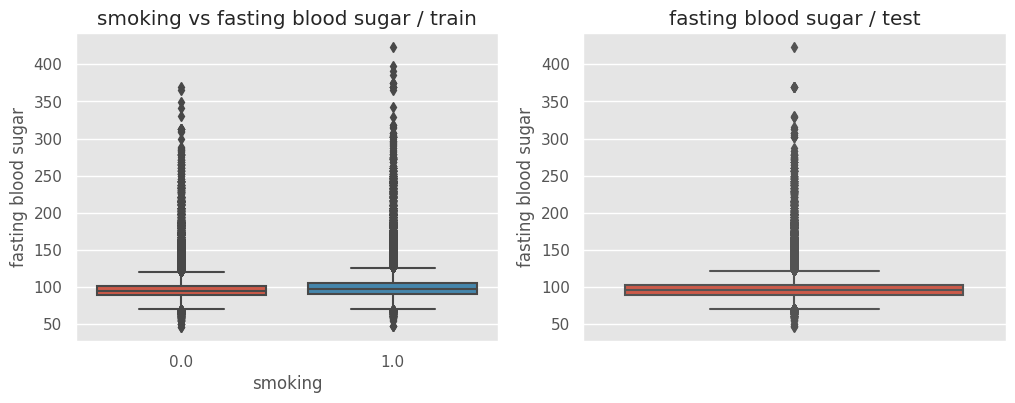

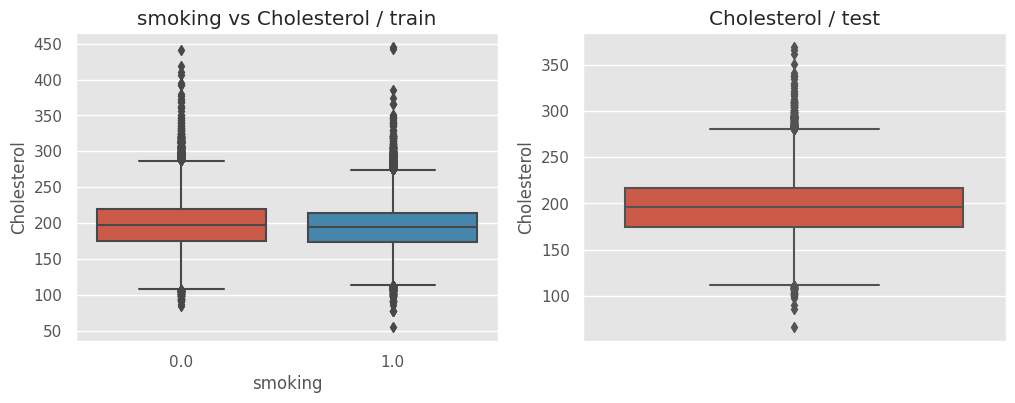

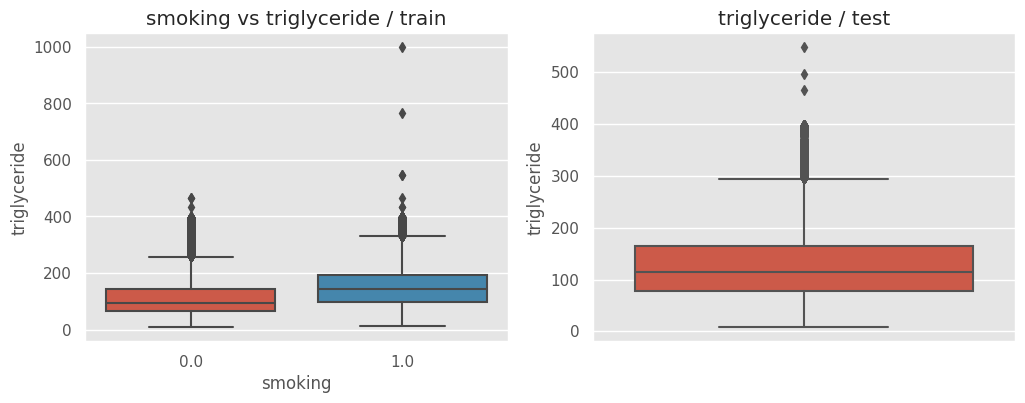

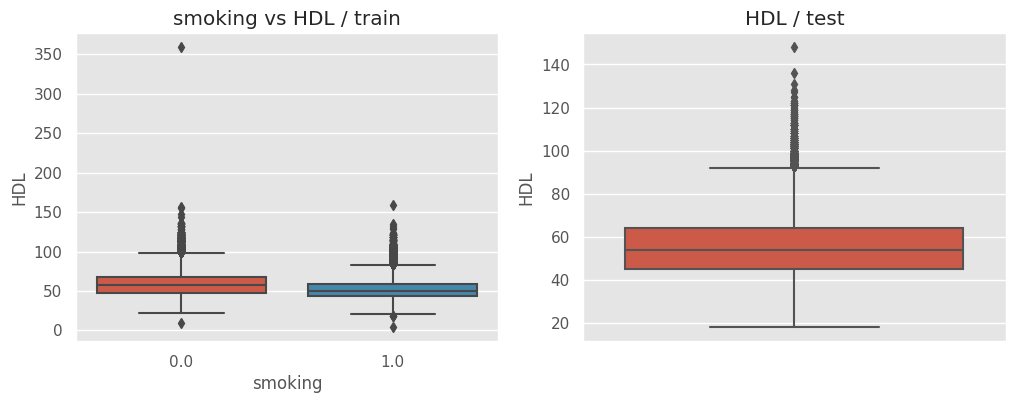

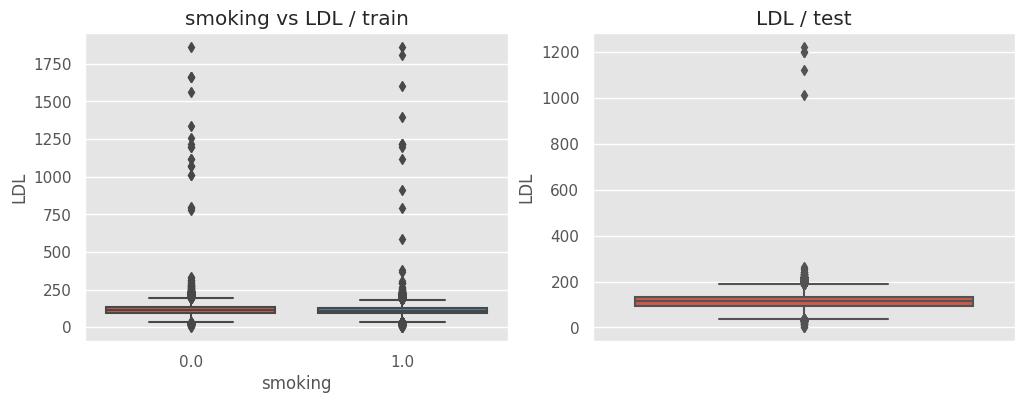

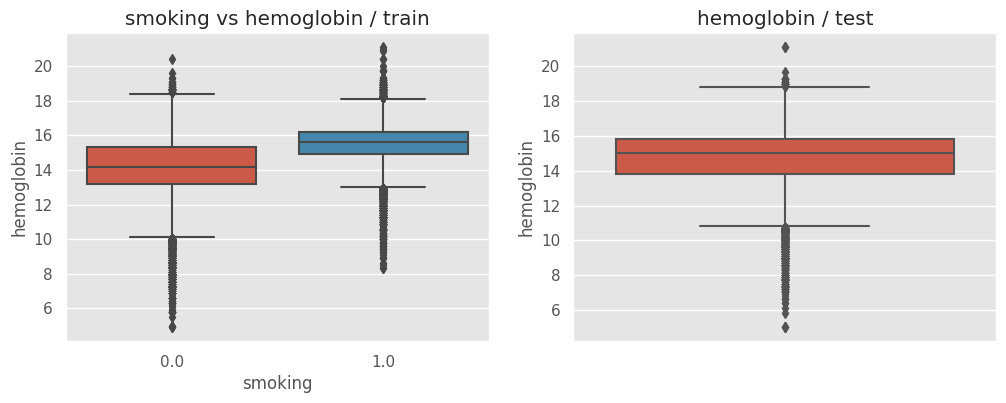

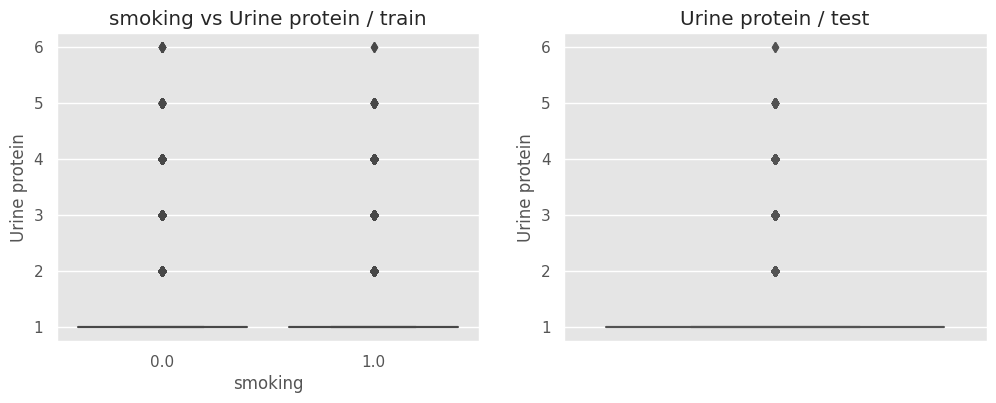

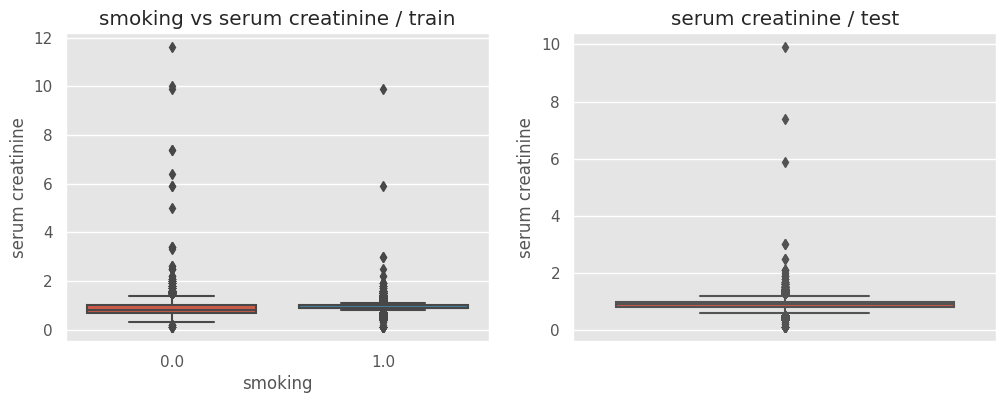

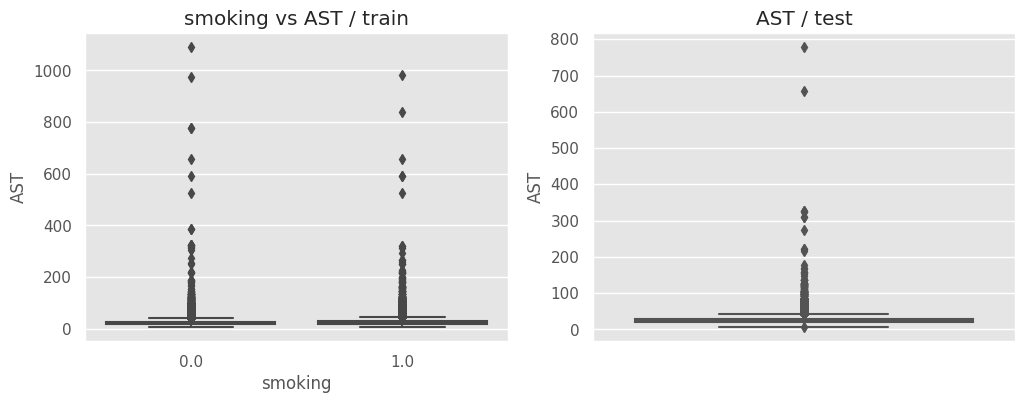

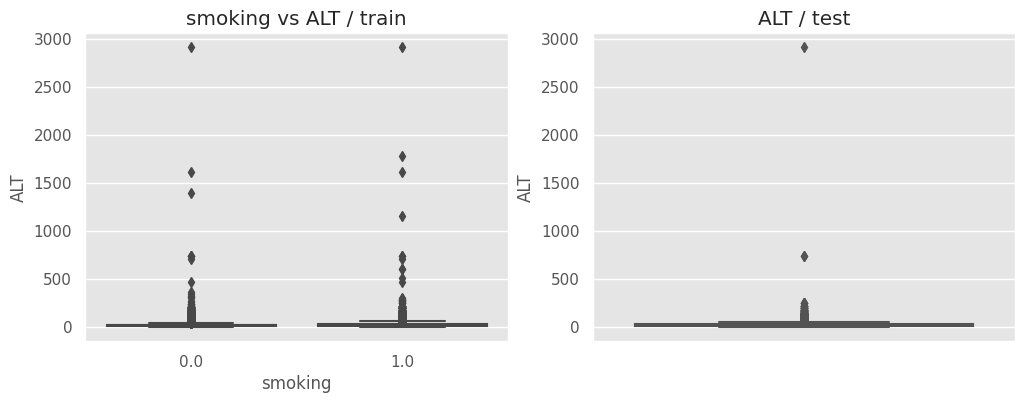

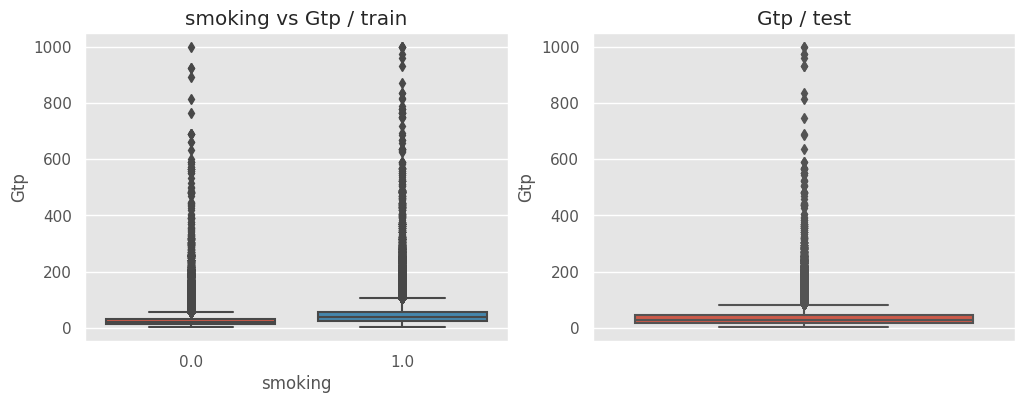

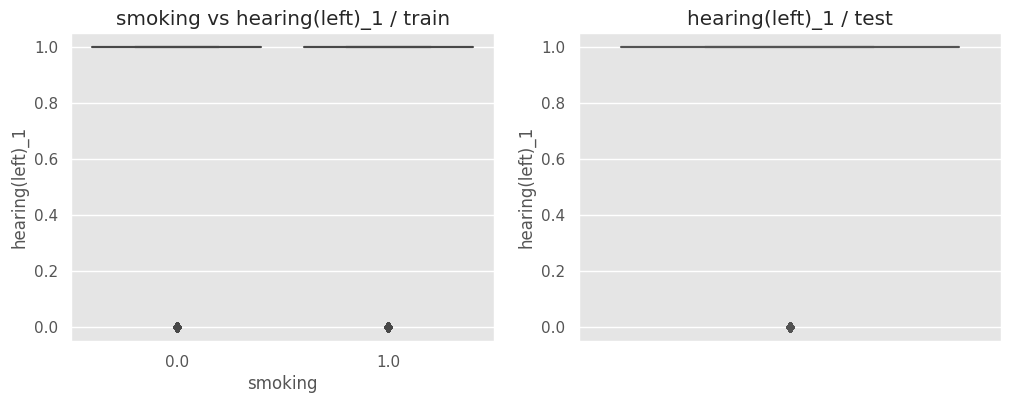

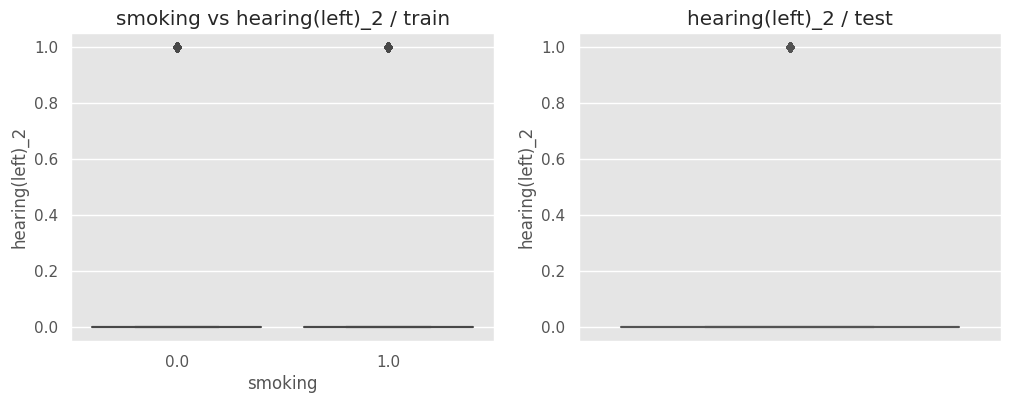

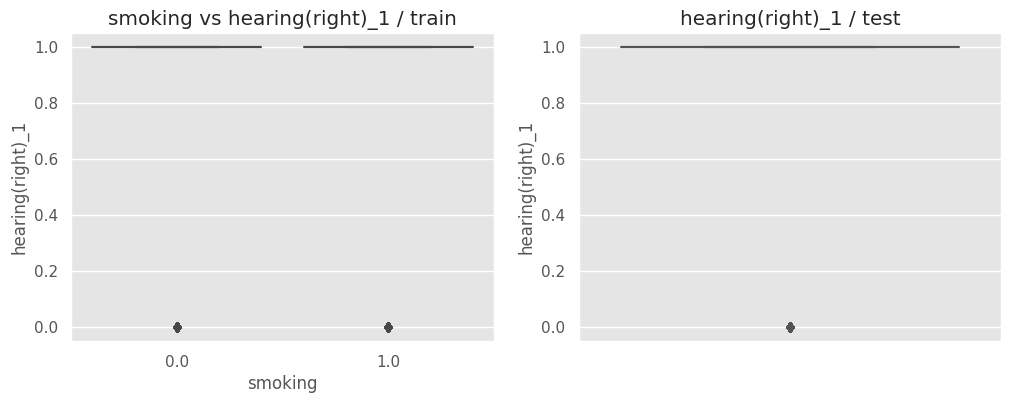

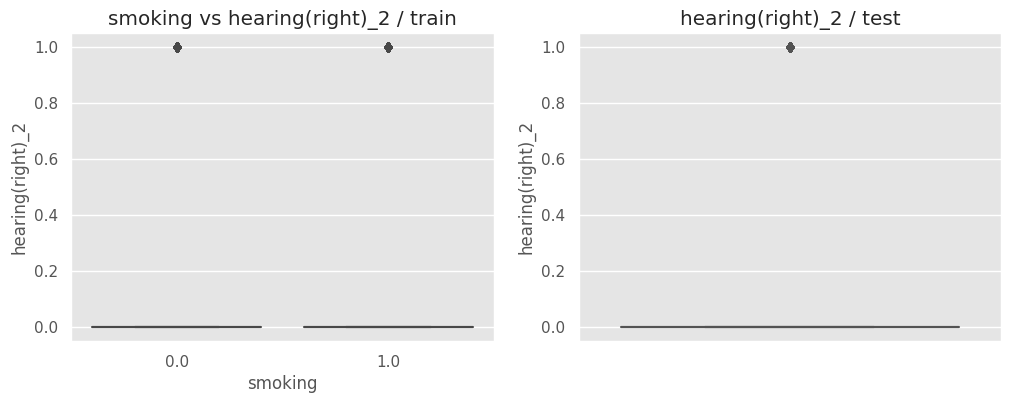

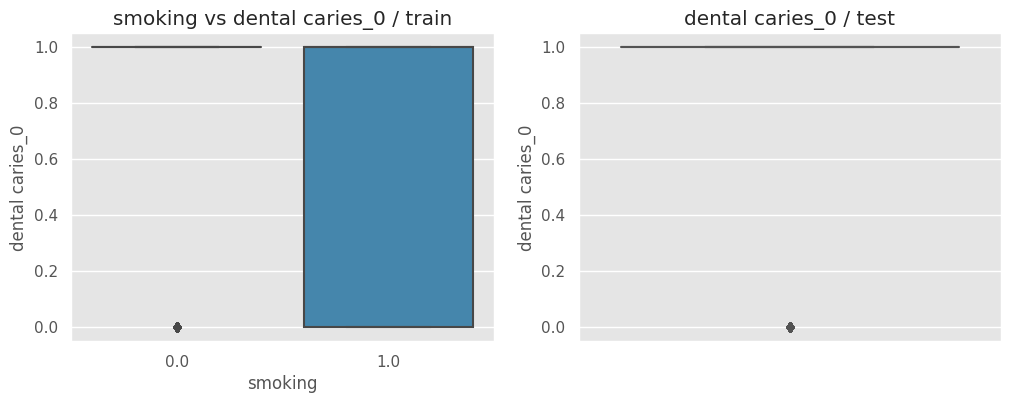

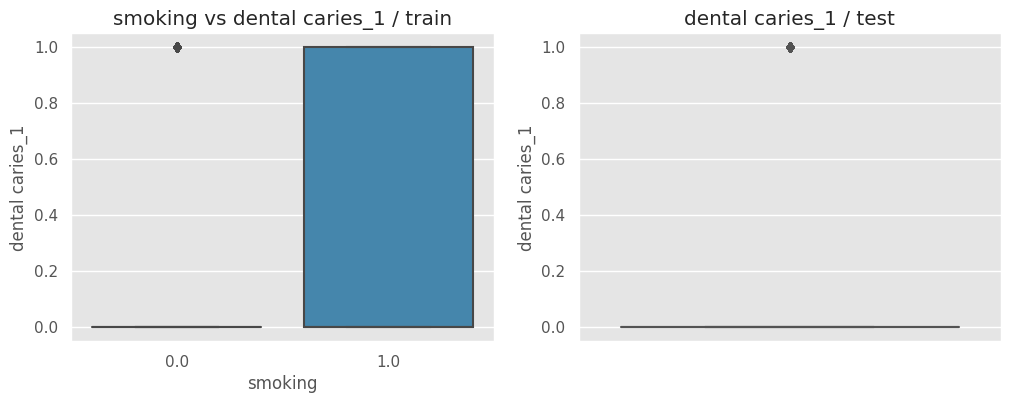

In [24]:
for feat in feat_test:
    plt.figure(figsize=(12,4))
    ax1 = plt.subplot(1,2,1)
    sns.boxplot(data=train, x='smoking', y=feat)
    plt.title('smoking vs ' + feat + ' / train')
    x1 = plt.subplot(1,2,2)
    sns.boxplot(data=test, y=feat)
    plt.title(feat + ' / test')
    plt.show()

Удаление выбросов

In [25]:
train = train.drop(train[train['triglyceride'] > 700].index)
train = train.drop(train[train['HDL'] > 350].index)
#train = train.drop(train[train['LDL'] > 1500].index)

train

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,smoking,hearing(left)_1,hearing(left)_2,hearing(right)_1,hearing(right)_2,dental caries_0,dental caries_1
0,0.0,55,165,60,81.0,0.5,0.6,135,87,94,172,300,40,75,16.5,1,1.0,22,25,27,1.0,1,0,1,0,1,0
1,1.0,70,165,65,89.0,0.6,0.7,146,83,147,194,55,57,126,16.2,1,1.1,27,23,37,0.0,0,1,0,1,0,1
2,2.0,20,170,75,81.0,0.4,0.5,118,75,79,178,197,45,93,17.4,1,0.8,27,31,53,1.0,1,0,1,0,1,0
3,3.0,35,180,95,105.0,1.5,1.2,131,88,91,180,203,38,102,15.9,1,1.0,20,27,30,0.0,1,0,1,0,0,1
4,4.0,30,165,60,80.5,1.5,1.0,121,76,91,155,87,44,93,15.4,1,0.8,19,13,17,1.0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192718,NaN,40,170,65,77.0,1.5,1.5,110,62,91,187,84,79,91,16.1,1,0.9,28,43,36,1.0,1,0,1,0,0,1
192719,NaN,40,165,60,80.0,0.4,0.6,107,60,93,144,53,61,72,12.3,1,0.5,18,18,21,0.0,1,0,1,0,0,1
192720,NaN,45,155,55,75.0,1.5,1.2,126,72,91,227,100,76,131,12.5,2,0.6,23,11,12,0.0,1,0,1,0,1,0
192721,NaN,40,160,55,75.0,1.5,1.5,95,69,102,206,48,79,116,12.0,1,0.6,24,20,17,1.0,1,0,1,0,1,0


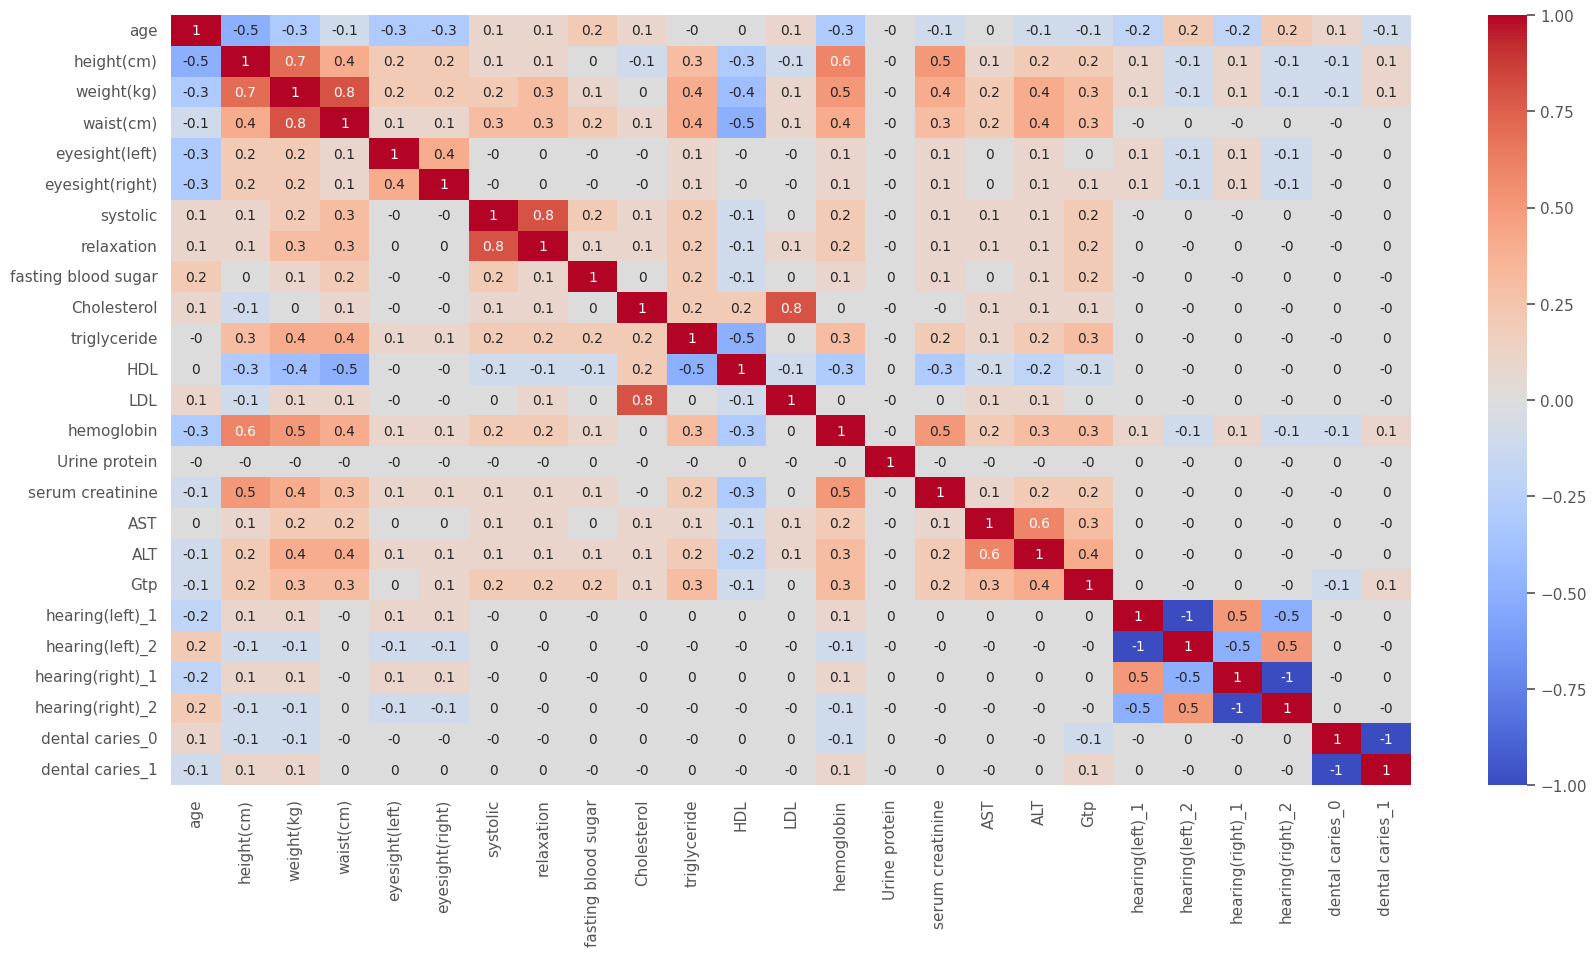

In [26]:
corr = test.drop(columns=['id', 'smoking']).corr().round(1)
plt.figure(figsize=(20,10))
sns.heatmap(corr, vmin=-1, vmax=1, center=0, square=False, annot=True, cmap='coolwarm')
plt.show()

# **Подготовка данных для обучения**

In [27]:
X = train[feat_test]
y = train['smoking']

In [28]:
X

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,hearing(left)_1,hearing(left)_2,hearing(right)_1,hearing(right)_2,dental caries_0,dental caries_1
0,55,165,60,81.0,0.5,0.6,135,87,94,172,300,40,75,16.5,1,1.0,22,25,27,1,0,1,0,1,0
1,70,165,65,89.0,0.6,0.7,146,83,147,194,55,57,126,16.2,1,1.1,27,23,37,0,1,0,1,0,1
2,20,170,75,81.0,0.4,0.5,118,75,79,178,197,45,93,17.4,1,0.8,27,31,53,1,0,1,0,1,0
3,35,180,95,105.0,1.5,1.2,131,88,91,180,203,38,102,15.9,1,1.0,20,27,30,1,0,1,0,0,1
4,30,165,60,80.5,1.5,1.0,121,76,91,155,87,44,93,15.4,1,0.8,19,13,17,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192718,40,170,65,77.0,1.5,1.5,110,62,91,187,84,79,91,16.1,1,0.9,28,43,36,1,0,1,0,0,1
192719,40,165,60,80.0,0.4,0.6,107,60,93,144,53,61,72,12.3,1,0.5,18,18,21,1,0,1,0,0,1
192720,45,155,55,75.0,1.5,1.2,126,72,91,227,100,76,131,12.5,2,0.6,23,11,12,1,0,1,0,1,0
192721,40,160,55,75.0,1.5,1.5,95,69,102,206,48,79,116,12.0,1,0.6,24,20,17,1,0,1,0,1,0


In [29]:
y

0         1.0
1         0.0
2         1.0
3         0.0
4         1.0
         ... 
192718    1.0
192719    0.0
192720    0.0
192721    1.0
192722    1.0
Name: smoking, Length: 192720, dtype: float64

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [31]:
X_train

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,hearing(left)_1,hearing(left)_2,hearing(right)_1,hearing(right)_2,dental caries_0,dental caries_1
56276,60,165,70,88.0,0.5,0.6,160,96,95,228,152,50,148,15.1,1,0.9,21,15,27,1,0,1,0,1,0
149831,45,155,55,73.4,1.2,1.2,120,60,100,247,85,89,141,12.8,1,0.6,20,12,10,1,0,1,0,1,0
23732,55,165,70,86.0,0.9,1.0,142,91,103,216,131,54,135,16.4,1,1.1,21,20,48,1,0,1,0,1,0
157380,30,175,80,90.0,0.8,0.6,130,85,98,189,228,41,102,16.2,1,0.9,23,33,28,1,0,1,0,1,0
153863,25,175,65,78.0,1.2,1.0,110,70,90,139,72,53,72,16.0,1,0.9,20,19,14,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73350,50,160,60,86.0,0.7,0.8,122,97,97,184,104,41,122,14.1,1,1.0,18,16,25,1,0,1,0,1,0
109260,25,175,75,77.3,0.5,0.5,110,70,95,132,73,42,75,15.6,1,0.9,18,11,14,1,0,1,0,1,0
50057,35,170,85,98.0,1.2,1.2,120,84,108,206,260,53,102,15.3,1,1.1,25,40,66,1,0,1,0,1,0
5192,55,170,65,91.5,0.9,1.0,124,72,112,232,184,54,141,15.0,1,1.0,25,20,28,1,0,1,0,1,0


# **Создание нейронной сети**

In [32]:
#neural network
from tensorflow import keras
from tensorflow.keras import layers, callbacks

early_stopping = callbacks.EarlyStopping(
    min_delta=0.01,
    patience=50, 
    restore_best_weights=True,
)

model = keras.Sequential([
    layers.BatchNormalization(input_shape=[25]),
    layers.Dense(256, activation='relu'),
    layers.Dropout(rate=0.3),
    
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(rate=0.2),
    
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(rate=0.3),
    
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(rate=0.2),
    
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(rate=0.3),
    
    layers.BatchNormalization(),
    layers.Dense(1, activation='sigmoid'),
])

In [33]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

**Понадобилось около 200 эпох, дальше идет переобучение нейронной сети,**

In [34]:
# history = model.fit(
#     X_train, y_train,
#     validation_data=(X_test, y_test),
#     batch_size=1024,
#     epochs=1000,
# )

# **Предсказание**

In [35]:
# id_ = test.id
# test = test.drop(columns=['id', 'smoking']).copy()
# y_pred = model.predict(test)
# y_pred = pd.DataFrame(y_pred)
# y_pred = pd.Series(y_pred[0])
# y_pred = abs(y_pred)
# id_ = id_.reset_index()
# id_

**Лучший результат был сохранен в файл  submission (1).csv, импортируем и отвечаем в соревновании**

In [37]:
sub1 = pd.read_csv('/kaggle/input/submission/submission (1).csv')

In [38]:
output = pd.DataFrame({'id': sub1.id, 'smoking': sub1.smoking})
output.to_csv('submission.csv', index=False)

In [39]:
output

,id,smoking
0,159256.0,0.542645
1,159257.0,0.428484
2,159258.0,0.460016
3,159259.0,0.015454
4,159260.0,0.629629
...,...,...
106166,265422.0,0.418187
106167,265423.0,0.721561
106168,265424.0,0.280024
106169,265425.0,0.202216
